In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

import os.path

%matplotlib inline

In [46]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [48]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [49]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        
        # the tensor [latent_size x 1] representing the average activations of each hidden unit j over batch(!)
        self.data_rho = h.mean(0)
        
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        
        Thus D_KL(P||Q) is proportional to  (-p*log(q) - (1-p)*log(1-q))
        """
        dkl = -rho * torch.log(self.data_rho) - (1-rho) * torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [50]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [51]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [52]:
model_filename = './model_64.h5'

In [53]:
if not os.path.isfile(model_filename):
    models = {'16': Net(16), '32': Net(32), '64': Net(64)}
    rho = 0.05
    train_log = {k: [] for k in models}
    test_log = {k: [] for k in models}

    [model.to(device) for model in models.values()];

In [54]:
# Train if no model has been pretrained
if not os.path.isfile(model_filename):
    for epoch in range(1, 21):
        for model in models.values():
            model.train()
        train(epoch, models, train_log)
        for model in models.values():
            model.eval()
        test(models, valid_loader, test_log)

In [55]:
if not os.path.isfile(model_filename):
    # save the model
    torch.save(models['64'], model_filename)

In [56]:
model64 = torch.load(model_filename)

In [59]:
data, _ = next(iter(test_loader))
output = model64(data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = model64.decode(torch.eye(64).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = model64.E(data.view(-1, 28*28).to(device))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model64.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([ 5,  4,  2,  8,  7,  4,  4,  4,  5,  3,  8,  5,  4,  5,
         4,  6,  5,  5,  2,  2,  4,  8,  5,  5,  2,  7,  6,  5,
         5,  6,  3,  4,  5,  4,  5,  7,  4,  4,  3,  3,  5,  2,
         5,  0,  7,  3,  7,  3,  8,  9])


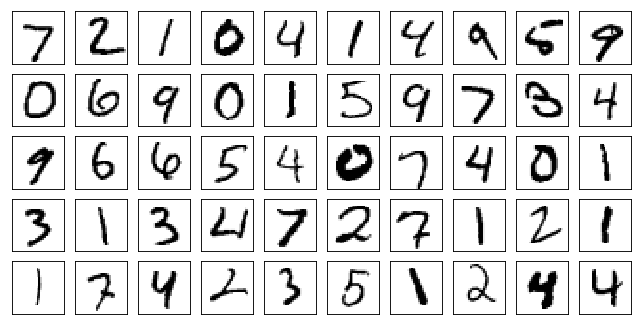

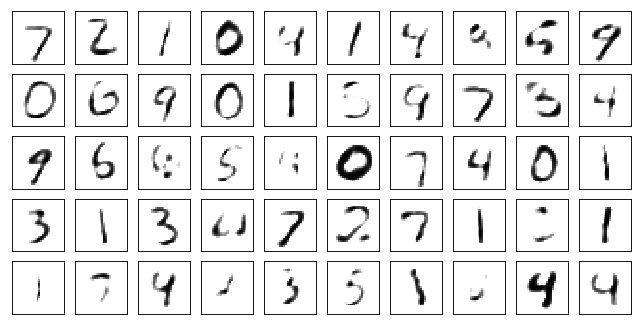

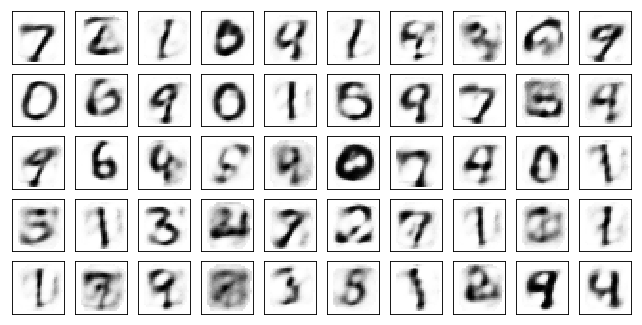

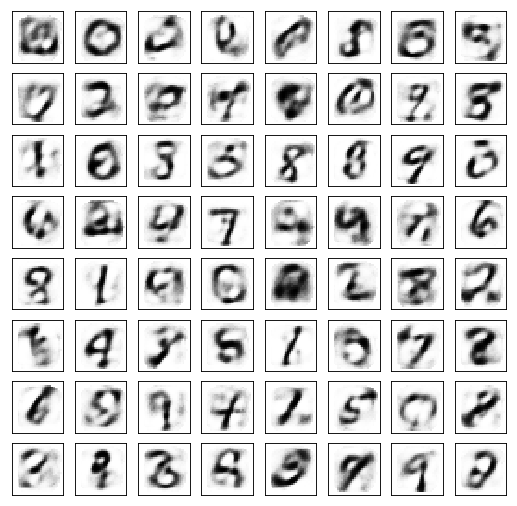

In [60]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

### 1. initialize inputs with all zeros

In [61]:
inputs = torch.zeros([64, 1, 28, 28])
print("Sum of elements: {}".format(inputs.sum().item()))
print("Tensor shape: {}".format(inputs.shape))

Sum of elements: 0.0
Tensor shape: torch.Size([64, 1, 28, 28])


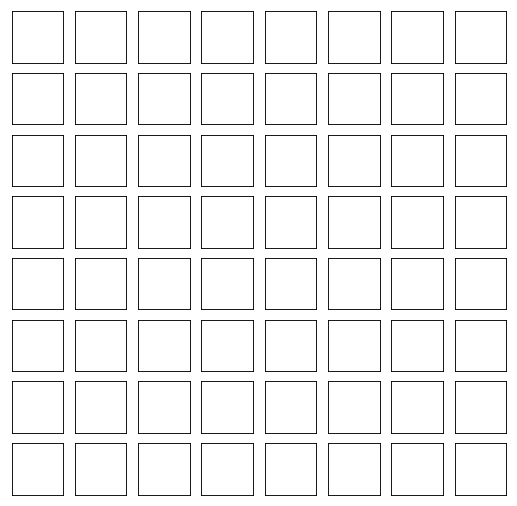

In [62]:
inputs_to_plot = ((inputs.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(inputs_to_plot, shape=(8, 8))

In [63]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [64]:
def step(i, print_every=100):
    inputs_optim.zero_grad()
    
    # calculate loss b/w 
    loss = F.mse_loss(model64.E(w.view(-1, 28*28)), torch.eye(64))    
    loss_ = loss.item()
    loss.backward()
    
    # print
    if i % print_every == 0:
        print("{}\t{:.7f} {:.7f}".format(i, loss_, w.grad.sum().item()))
    
    inputs_optim.step()
    return loss_

In [65]:
def iterate_inputs(eps=1e-4):
    i = 0
    loss_ = 1
    print("i\tloss      grad.sum()")
    while loss_ > eps: 
        loss_ = step(i, 500)
        i += 1

In [66]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.2447497 0.6789843
500	0.0352568 0.1471856
1000	0.0146104 0.0589115
1500	0.0074119 0.0320014
2000	0.0043191 0.0192878
2500	0.0027420 0.0125177
3000	0.0018408 0.0085121
3500	0.0012840 0.0060091
4000	0.0009203 0.0043139
4500	0.0006728 0.0031804
5000	0.0004992 0.0023653
5500	0.0003746 0.0017823
6000	0.0002836 0.0013533
6500	0.0002162 0.0010328
7000	0.0001659 0.0007924
7500	0.0001278 0.0006124


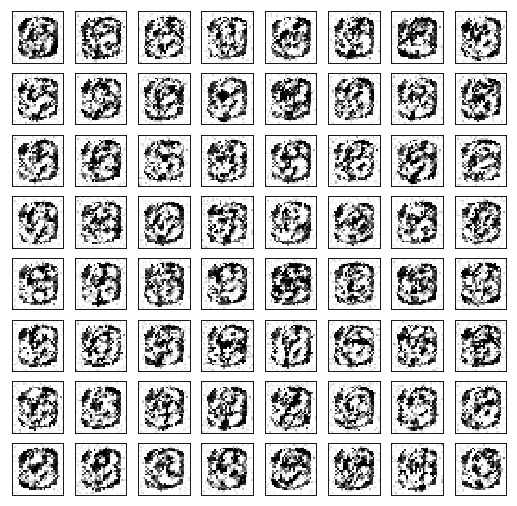

In [67]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

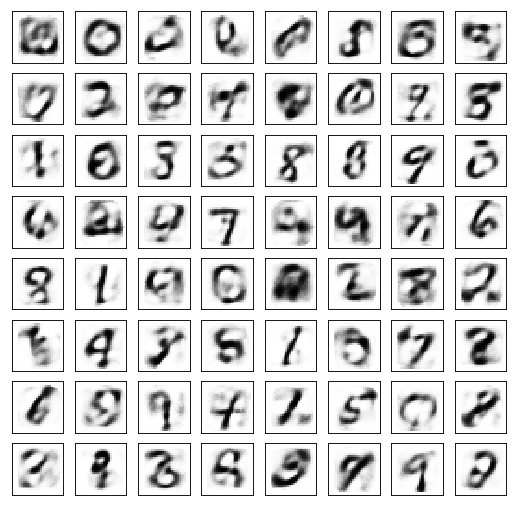

In [68]:
decoded = model64.D(model64.E(w.view(-1, 28*28)))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(dec_to_plot, shape=(8, 8))

### 2. Initialze inputs with real cifers

In [69]:
train_loader, valid_loader, test_loader = mnist(batch_size=64, valid=10000, transform=mnist_transform)
inputs, _ = next(iter(test_loader))
inputs.shape

torch.Size([64, 1, 28, 28])

In [70]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [71]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.0263929 0.0378658
500	0.0077260 0.0029607
1000	0.0030244 0.0022161
1500	0.0018359 0.0010460
2000	0.0007924 0.0008675
2500	0.0006724 0.0005651
3000	0.0003792 0.0004326
3500	0.0003374 0.0003081
4000	0.0003120 0.0002276
4500	0.0002949 0.0001739
5000	0.0002827 0.0001345
5500	0.0002738 0.0001048
6000	0.0002672 0.0000826


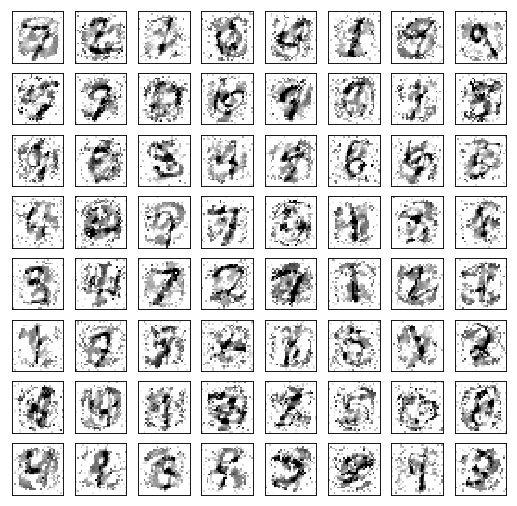

In [72]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

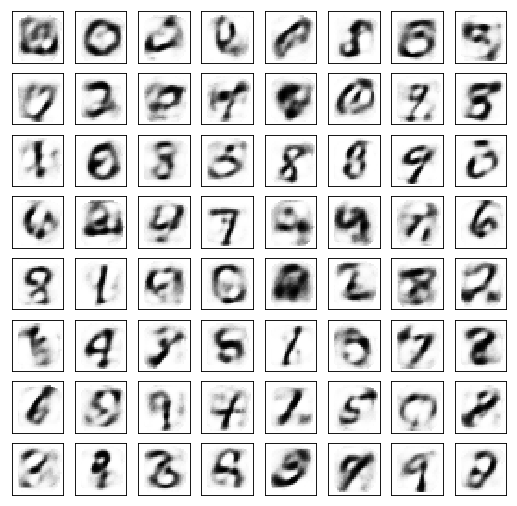

In [73]:
decoded = model64.D(model64.E(w.view(-1, 28*28)))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(dec_to_plot, shape=(8, 8))

### 3. Initialze inputs with ones

In [74]:
inputs = torch.ones([64, 1, 28, 28])
print("Sum of elements: {}".format(inputs.sum().item()))
print("Tensor shape: {}".format(inputs.shape))

Sum of elements: 50176.0
Tensor shape: torch.Size([64, 1, 28, 28])


In [75]:
w = torch.nn.Parameter(inputs)
inputs_optim = optim.Adam(params=[w], lr=1e-3)

In [76]:
iterate_inputs(eps=1e-4)

i	loss      grad.sum()
0	0.3736448 0.1289733
500	0.2713238 0.0567698
1000	0.2513454 0.0158432
1500	0.2437330 0.0044556
2000	0.2206280 0.0066330
2500	0.2048026 0.0076974
3000	0.1919557 0.0059569
3500	0.1871262 0.0037805
4000	0.1846170 0.0026018
4500	0.1829558 0.0020739
5000	0.1817484 0.0016834
5500	0.1806282 0.0011722
6000	0.1799687 0.0008886
6500	0.1795075 0.0006278
7000	0.1791371 0.0004706
7500	0.1790469 0.0003528
8000	0.1789955 0.0002424
8500	0.1789647 0.0001711
9000	0.1789439 0.0001392
9500	0.1789289 0.0001036
10000	0.1789187 0.0000777
10500	0.1789117 0.0000606
11000	0.1789068 0.0000459
11500	0.1789030 0.0000369
12000	0.1789002 0.0000297
12500	0.1788981 0.0000233
13000	0.1788965 0.0000196
13500	0.1788936 0.0000208
14000	0.1786533 0.0000310
14500	0.1786513 0.0000173
15000	0.1786502 0.0000122
15500	0.1786495 0.0000096
16000	0.1786492 0.0000074
16500	0.1786489 0.0000063
17000	0.1786486 0.0000053
17500	0.1786484 0.0000043
18000	0.1786482 0.0000037
18500	0.1786481 0.0000033
19000	0.17864

KeyboardInterrupt: 

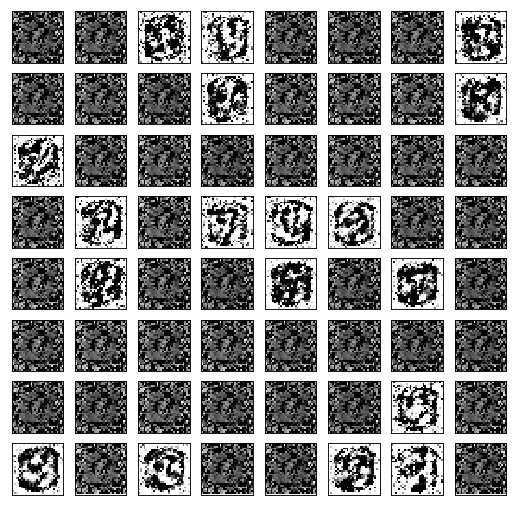

In [77]:
w_to_plot = ((w.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(w_to_plot, shape=(8, 8))

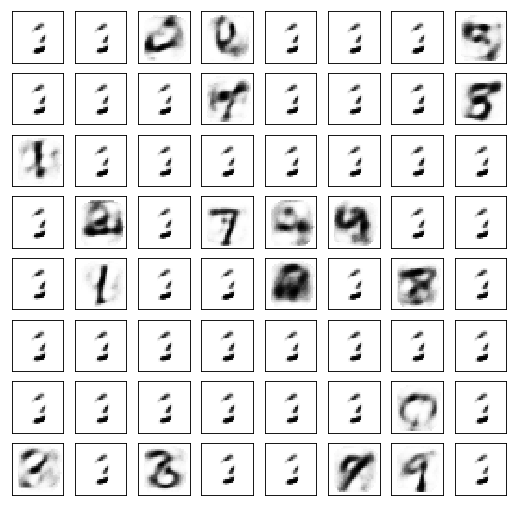

In [78]:
decoded = model64.D(model64.E(w.view(-1, 28*28)))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
plot_mnist(dec_to_plot, shape=(8, 8))

**Выводы**
1. При инициализации батча картинок размером [64, 1, 28, 28] нулевыми значениями - мы находим входные изображения, соответствующие максимальным входным активациям каждого из 64 нейронов.
2. Однако в случае инициализации реальными картинками мы замечаем, что некоторые пиксели не изменяют своего значения или именяют на небольшое значение (остаются черными), то есть практически не вносят вклад в конечный one-hot вектор активаций на выходе кодировщика
3. Если инициализировать входной батч единичными значениями, алгоритм не сходится для некоторых one-hot векторов.